In karaoke, lyrics are presented on screen in rough synchronization with the appropriate portion of the song. However, unless manually done, the lyric guide (pointer/highlight over the appropriate word to be sung at a time) is absent. I attempt to automate this process.

The high level idea is to use a pre-trained network (RNN?) on speech transcription, then use a similar idea to an image heatmap in CNNs to find the portion of the audio input that contributed most to the chosen word. With these time markers, we now have a lyric guide.

Background: speech-to-text networks, CNN heatmaps

## Apporach 1: Using GRAD-CAM on CNN's

#### For this, an end-to-end CNN for ASR and apply the GRAD-CAM method described by Selvaraju et. al (2016) in [this paper](https://arxiv.org/abs/1610.02391).

### Approach 1a: I will implement [this paper](https://arxiv.org/pdf/1701.02720.pdf) by Zhang et. al (2017) for the CNN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
""" Preprocessing

Note: nn in torch expects everything as mini-batches, so single sample should be mini-batch of size 1

1. Get input audio from dataset (TIMIT, LibraSpeech)
2. Split into Training, Validation, and Test (use DataLoader)
3. Do appropriate transformations to get input features

"""

' Preprocessing\n\nNote: nn in torch expects everything as mini-batches, so single sample should be mini-batch of size 1\n\n1. Get input audio from dataset (TIMIT, LibraSpeech)\n2. Split into Training, Validation, and Test (use DataLoader)\n3. Do appropriate transformations to get input features\n\n'

In [3]:
def get_libri_speech_dataset(dataset_dir: str, dataset: str="train-clean-100") -> torch.utils.data.Dataset:

    """
    Function to download LibriSpeech dataset.

    Inputs: 
    dataset_dir -- Path to directory where dataset should be located/downloaded
    dataset -- Type of dataset desired. Options are "train-clean-100", "train-clean-360", "train-clean-500", "dev-clean", "dev-other", "test-clean", "test-other"
    dataset

    Output: torch.utils.data.Dataset of tuples with contents (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
    """

    # can use either key or url for "url" parameter of dataset download function
    # libra_speech_urls = {"train-clean-100" : "https://www.openslr.org/resources/12/train-clean-100.tar.gz", \
    #                     "train-clean-360" : "https://www.openslr.org/resources/12/train-clean-360.tar.gz", \
    #                     "train-clean-500" : "https://www.openslr.org/resources/12/train-other-500.tar.gz", \
    #                     "dev-clean" : "https://www.openslr.org/resources/12/dev-clean.tar.gz", \
    #                     "dev-other" : "https://www.openslr.org/resources/12/dev-other.tar.gz", \
    #                     "test-clean" : "https://www.openslr.org/resources/12/test-clean.tar.gz", \
    #                     "test-other" : "https://www.openslr.org/resources/12/test-other.tar.gz"}

    return torchaudio.datasets.LIBRISPEECH(dataset_dir, url=dataset, download=True)

PATH_TO_DATASET_DIR = "/mnt/d/Datasets/LibriSpeech"

dataset = get_libri_speech_dataset(PATH_TO_DATASET_DIR)
len(dataset)

977

In [4]:
dataset[0]

(tensor([[ 1.3123e-03,  2.5635e-03,  1.5259e-03,  ..., -3.9062e-03,
          -3.0518e-05, -1.9531e-03]]),
 16000,
 'EVERY PROMISE OF THE SOUL HAS INNUMERABLE FULFILMENTS EACH OF ITS JOYS RIPENS INTO A NEW WANT NATURE UNCONTAINABLE FLOWING FORELOOKING',
 1088,
 129236,
 0)

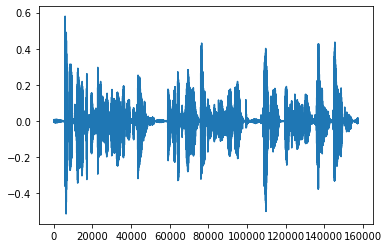

In [9]:
plt.plot(dataset[0][0][0])

In [18]:
mfcc_features = torchaudio.transforms.MFCC(log_mels=True)(dataset[0][0][0])
# Takes in audio of dimension (..., time) returns specgram_mel of size (..., n_mfcc, time) where n_mfcc defaults to 40
mfcc_features.shape

torch.Size([40, 788])

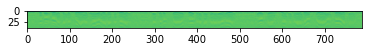

In [19]:
plt.imshow(mfcc_features)

In [9]:
class ASR_1(nn.Module):

        """Unlike the other layers, the first convolutional layer is followed by a pooling layer, which is described in section 2. The pooling size is 3 × 1, which means
        we only pool over the frequency axis. The filter size is 3 × 5
        across the layers. The model has 128 feature maps in the first
        four convolutional layers and 256 feature maps in the remaining
        six convolutional layers. Each fully-connected layer has 1024
        units. Maxout with 2 piece-wise linear functions is used as the
        activation function.""" 

        def __init__(self):
            super(ASR_1, self).__init__()
            # in_dim should be 40-dimensional from log MFCC + extra from deltas and delta-deltas = 123 total
            # should just be equal to dimensions of input features
            self.in_dim = 123
            self.conv1 = nn.Conv2d(self.in_dim, 128, (3, 5))
            self.pool = nn.MaxPool2d((3, 1))
            self.conv2 = nn.Conv2d(128, 128, (3, 5))
            self.conv3 = nn.Conv2d(128, 128, (3, 5))
            self.conv4 = nn.Conv2d(128, 128, (3, 5))
            self.conv5 = nn.Conv2d(128, 256, (3, 5))
            self.conv6 = nn.Conv2d(256, 256, (3, 5))
            self.conv7 = nn.Conv2d(256, 256, (3, 5))
            self.conv8 = nn.Conv2d(256, 256, (3, 5))
            self.conv9 = nn.Conv2d(256, 256, (3, 5))
            self.conv10 = nn.Conv2d(256, 256, (3, 5))
            # first arg of fc1 should be w * h of input features * 256
            self.fc1 = nn.Linear(1, 1028)
            self.fc2 = nn.Linear(1028, 1028)


        def forward():
            pass

        def maxout():
            pass


In [14]:
net = ASR_1()
net

ASR_1(
  (conv1): Conv2d(123, 128, kernel_size=(3, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 5), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 5), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 5), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1))
  (conv8): Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1))
  (conv9): Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1))
  (conv10): Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1))
  (fc1): Linear(in_features=1, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=1028, bias=True)
)

In [13]:
params = list(net.parameters())
len(params)

24